# 基于词向量的英汉翻译——“火炬上的深度学习"下第一次作业

在这个作业中，你需要半独立地完成一个英文到中文的单词翻译器

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第VI课的配套源代码

In [1]:
# 加载必要的程序包
# PyTorch的程序包
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 数值运算和绘图的程序包
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


# 加载机器学习的软件包，主要为了词向量的二维可视化
from sklearn.decomposition import PCA

#加载Word2Vec的软件包
import gensim as gensim
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.word2vec import LineSentence

#加载正则表达式处理的包
import re

#在Notebook界面能够直接显示图形
%matplotlib inline

## 第一步：加载词向量

首先，让我们加载别人已经在大型语料库上训练好的词向量

In [14]:
# 加载中文词向量，下载地址为：链接：http://pan.baidu.com/s/1gePQAun 密码：kvtg
# 该中文词向量库是由尹相志提供，训练语料来源为：微博、人民日报、上海热线、汽车之家等，包含1366130个词向量
#word_vectors = KeyedVectors.load_word2vec_format('vectors.bin', binary=True, unicode_errors='ignore')
#len(word_vectors.vocab)

1366130

In [17]:
# 加载中文的词向量，下载地址为：http://nlp.stanford.edu/data/glove.6B.zip，解压后将glove.6B.100d.txt文件拷贝到与本notebook
# 文件一致的文件夹洗面。
#f = open('glove.6B.100d.txt', 'r')
#i = 1

# 将英文的词向量都存入如下的字典中
#word_vectors_en = {}
#with open('glove.6B.100d.txt') as f:
#    for line in f:
#        numbers = line.split()
#        word = numbers[0]
#        vectors = np.array([float(i) for i in numbers[1 : ]])
#        word_vectors_en[word] = vectors
#        i += 1
#print(len(word_vectors_en))

400000


## 第二步：可视化同一组意思词在两种不同语言的词向量中的相互位置关系

In [32]:
# 中文的一二三四五列表
#cn_list = {'一', '二', '三', '四', '五', '六', '七', '八', '九', '零'}
# 阿拉伯数字的12345列表
#en_list = {'1', '2', '3', '4', '5', '6', '7', '8', '9', '0'}
# 英文数字的列表
#en_list = {'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero'}

# 对应词向量都存入到列表中
#cn_vectors = []  #中文的词向量列表
#en_vectors = []  #英文的词向量列表
#for w in cn_list:
#    cn_vectors.append(word_vectors[w])
#for w in en_list:
#    en_vectors.append(word_vectors_en[w])

# 将这些词向量统一转化为矩阵
#cn_vectors = np.array(cn_vectors)
#en_vectors = np.array(en_vectors)

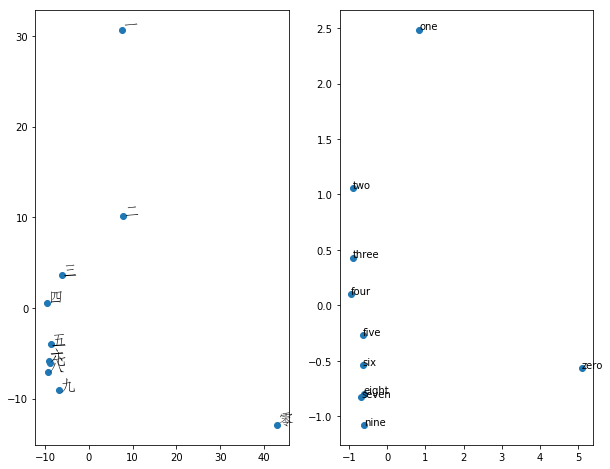

In [33]:
# 降维实现可视化
#X_reduced = PCA(n_components=2).fit_transform(cn_vectors)
#Y_reduced = PCA(n_components = 2).fit_transform(en_vectors)

# 绘制所有单词向量的二维空间投影
#f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 8))
#ax1.plot(X_reduced[:, 0], X_reduced[:, 1], 'o')
#ax2.plot(Y_reduced[:, 0], Y_reduced[:, 1], 'o')
#zhfont1 = matplotlib.font_manager.FontProperties(fname='/Library/Fonts/华文仿宋.ttf', size=16)
#for i, w in enumerate(cn_list):
#    ax1.text(X_reduced[i, 0], X_reduced[i, 1], w, fontproperties = zhfont1, alpha = 1)
#for i, w in enumerate(en_list):
#    ax2.text(Y_reduced[i, 0], Y_reduced[i, 1], w, alpha = 1)

### 结论：可以看出，中文的一、二、等数字彼此之间的关系与英文的数字彼此之间的关系很类似

## 第三步：训练一个神经网络，输入一个英文单词的词向量，输出一个中文的词向量，并翻译为中文

首先，读入一个已经建立好的词典（dictionary.txt）。本词典是老师调用百度翻译的API，自动将一篇英文小说中的词汇逐个翻译为中文而得来的

我们一个个地载入词典，并查找对应的中文词向量，如果找得到，则放入original_words中，做为正式的训练集

In [629]:
#original_words = []
#with open('dictionary.txt', 'r') as f:
#    dataset = []
#    for line in f:
#        itm = line.split('\t')
#        eng = itm[0]
#        chn = itm[1].strip()
#        if eng in word_vectors_en and chn in word_vectors:
#            data = word_vectors_en[eng]
#            target = word_vectors[chn]
            # 将中英文词对做成数据集
#            dataset.append([data, target])
#            original_words.append([eng, chn])
#print(len(dataset)) # 共有4962个单词做为总的数据集合

4962


In [630]:
# 建立训练集、测试集和校验集
# 训练集用来训练神经网络，更改网络的参数；校验集用来判断网络模型是否过拟合：当校验集的损失数值超过训练集的时候，即为过拟合
# 测试集用来检验模型的好坏
#indx = np.random.permutation(range(len(dataset)))
#dataset = [dataset[i] for i in indx]
#original_words = [original_words[i] for i in indx]
#train_size = 500
#train_data = dataset[train_size:]
#valid_data = dataset[train_size // 2 : train_size]
#test_data = dataset[: train_size // 2]
#test_words = original_words[: train_size // 2]


In [655]:
# 开始训练一个多层神经网络，将一个100维度的英文向量映射为200维度的中文词向量，隐含层节点为30

#input_size = 100
#output_size = 200
#hidden_size = 30

# 新建一个神经网络，包含一个隐含层
#model = nn.Sequential(nn.Linear(input_size, hidden_size)
#                     nn.Tanh()
#                     nn.Linear(hidden_size, output_size)
#                     )

# 构造损失函数
#criterion = torch.nn.MSELoss()

# 构造优化器
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# 总的循环周期
#num_epoch = 100


#开始训练500次，每次对所有的数据都做循环
#results = []
#for epoch in range(num_epoch):
#    train_loss = []
#    for data in train_data:
        # 读入数据
#        x = Var(torch.FloatTensor(data[0])).unsqueeze(0)
#        y = Var(torch.FloatTensor(data[1])).unsqueeze(0)
        # 模型预测
#        output = model(x)
        
        # 反向传播算法训练
#        optimizer.zero()
#        loss = criteri(output, y)
#        train_loss.append(loss.data.numpy()[0])
#        loss.backwerd()
#        optimizer.step()
    # 在校验集上测试一下效果
#    valid_loss = []
#    for data in valid_data:
#        x = Var(torch.FloatTensor(data[0])).unsqueeze(0)
#        y = Var(torch.FloatTensor(data[1])).unsqueeze(0)
#        output = model(x)
#        loss = criterion(output, y)
#        valid_loss.append(loss.data.numpy()[0])
#    results.append([np.mean(train_loss), np.mean(valid_loss)])
#    print('{}轮，训练Loss: {:.2f}, 校验Loss: {:.2f}'.format(epoch, np.mean(train_loss), np.mean(valid_loss)))


0轮，训练Loss: 8.78, 校验Loss: 8.24
1轮，训练Loss: 8.35, 校验Loss: 7.95
2轮，训练Loss: 8.11, 校验Loss: 7.78
3轮，训练Loss: 7.96, 校验Loss: 7.67
4轮，训练Loss: 7.85, 校验Loss: 7.59
5轮，训练Loss: 7.77, 校验Loss: 7.52
6轮，训练Loss: 7.70, 校验Loss: 7.46
7轮，训练Loss: 7.64, 校验Loss: 7.42
8轮，训练Loss: 7.58, 校验Loss: 7.38
9轮，训练Loss: 7.54, 校验Loss: 7.34
10轮，训练Loss: 7.50, 校验Loss: 7.31
11轮，训练Loss: 7.46, 校验Loss: 7.28
12轮，训练Loss: 7.43, 校验Loss: 7.26
13轮，训练Loss: 7.40, 校验Loss: 7.24
14轮，训练Loss: 7.38, 校验Loss: 7.22
15轮，训练Loss: 7.35, 校验Loss: 7.21
16轮，训练Loss: 7.33, 校验Loss: 7.19
17轮，训练Loss: 7.31, 校验Loss: 7.18
18轮，训练Loss: 7.29, 校验Loss: 7.17
19轮，训练Loss: 7.28, 校验Loss: 7.16
20轮，训练Loss: 7.26, 校验Loss: 7.15
21轮，训练Loss: 7.25, 校验Loss: 7.14
22轮，训练Loss: 7.24, 校验Loss: 7.13
23轮，训练Loss: 7.22, 校验Loss: 7.12
24轮，训练Loss: 7.21, 校验Loss: 7.12
25轮，训练Loss: 7.20, 校验Loss: 7.11
26轮，训练Loss: 7.19, 校验Loss: 7.11
27轮，训练Loss: 7.18, 校验Loss: 7.10
28轮，训练Loss: 7.17, 校验Loss: 7.10
29轮，训练Loss: 7.17, 校验Loss: 7.09
30轮，训练Loss: 7.16, 校验Loss: 7.09
31轮，训练Loss: 7.15, 校验Loss: 7.08
32轮，训练Loss: 7.14, 

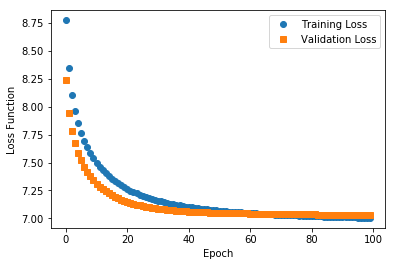

In [657]:
# 绘制图形
#a = [i[0] for i in results]
#b = [i[1] for i in results]
#plt.plot(a, 'o', label = 'Training Loss')
#plt.plot(b, 's', label = 'Validation Loss')
#plt.xlabel('Epoch')
#plt.ylabel('Loss Function')
#plt.legend()

In [658]:
# 在测试集上验证准确度
# 检验标准有两个：一个是直接用预测的词和标准答案做全词匹配；另一个是做单字的匹配
#exact_same = 0  #全词匹配数量
#one_same = 0 #单字匹配数量
#results = []
#for i, data in enumerate(test_data):
#    x = Var(torch.FloatTensor(data[0])).unsqueeze(0)
    # 给出模型的输出
#    output = model(x)
#    output = output.squeeze().data.numpy()
    # 从中文词向量中找到与输出向量最相似的向量
#    most_similar = word_vectors.wv.similar_by_vector(output, 1)
    # 将标准答案中的词与最相似的向量所对应的词打印出来
#    results.append([original_words[i][1], most_similar[0][0]])
    
    # 全词匹配
#    if original_words[i][1] == most_similar[0][0]:
#        exact_same += 1
    # 某一个字匹配
#    if list(set(list(original_words[i][1])) & set(list(most_similar[0][0]))) != []:
#        one_same += 1
    
#print("精确匹配率：{:.2f}".format(1.0 * exact_same / len(test_data)))
#print('一字匹配率：{:.2f}'.format(1.0 * one_same / len(test_data)))
#print(results)

精确匹配率：0.12
一字匹配率：0.20
[['过于', '也'], ['奥秘', '故事'], ['含', '制成'], ['武器', '武器'], ['化妆品', '内衣'], ['跳', '蹬'], ['露西', '女孩'], ['惊讶', '诧异'], ['标记', '清晰可见'], ['详细', '修改'], ['裂纹', '压住'], ['传染', '恐惧'], ['手电筒', '风扇'], ['培根', '奶油'], ['诉讼', '停止'], ['自己', '想'], ['鼓励', '鼓励'], ['功夫', '舞'], ['伤心', '悲伤'], ['可疑', '可疑'], ['嗨', '哇'], ['武器', '武器'], ['保护', '功能'], ['希望', '希望'], ['结巴', '停顿'], ['分辨率', '修改'], ['尝试', '摧毁'], ['跌跌撞撞', '停住'], ['筛选', '取样'], ['保持', '只要'], ['适合', '使用'], ['标志', '出现'], ['总是', '所以'], ['戳', '拧'], ['圆形', '内侧'], ['通知', '告知'], ['除非', '除非'], ['真空', '翻动'], ['我们', '我们'], ['粘', '粘'], ['1814', '1945'], ['挣扎', '陷入困境'], ['瞬间', '察觉'], ['接收机', '远端'], ['享受', '欣赏'], ['路', '公路'], ['真', '或者说'], ['群众', '载歌载舞'], ['实践', '必要'], ['对', '因为'], ['尴尬', '别扭'], ['梦想', '灵魂'], ['帽', '反光'], ['解体', '瓦解'], ['西红柿', '蜂蜜'], ['巴尼', 'judy'], ['按钮', '提手'], ['哦', '我'], ['片', '托盘'], ['继续', '促使'], ['旅行', '游玩'], ['激动', '惊恐'], ['小丑', '骷髅'], ['七十', '五十'], ['小调', '严重'], ['吐痰', '抽打'], ['高速公路', '缓冲区'], ['柱', '记事本'], ['洋葱', '肉'], ['帐篷', '